In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from datasetB_main import MyDataset
import numpy as np
import matplotlib.pyplot as plt
import tempfile

In [2]:
import shutil
shutil.rmtree('./tmp')
tmp_dir = tempfile.mkdtemp()

builder = MyDataset(data_dir='tmp')
builder.download_and_prepare(
	download_dir='tmp',
	download_config=tfds.download.DownloadConfig(manual_dir='tmp')
)
dataset_train_raw = builder.as_dataset(split='train')
dataset_test_raw = builder.as_dataset(split='test')
dataset_val_raw = builder.as_dataset(split='val')
dataset_info = builder.info

print(dataset_info)

2024-12-04 20:09:39.914507: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
                                                                        

Dataset my_dataset downloaded and prepared to tmp/my_dataset/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='my_dataset',
    full_name='my_dataset/1.0.0',
    description="""
    Dataset B pour le pierre papier ciseaux
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/my_dataset',
    data_dir='tmp/my_dataset/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=70.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=720, num_shards=1>,
        'train': <SplitInfo num_examples=3360, num_shards=1>,
        'val': <SplitInfo num_examples=720, num_shards=1>,
    },
    citation="""""",
)


In [3]:
print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(dataset_train_raw), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(dataset_test_raw), '\n')

Raw train dataset: <_PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Raw train dataset size: 3360 

Raw test dataset: <_PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Raw test dataset size: 720 



In [4]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_VAL_EXAMPLES = dataset_info.splits['val'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 3360
Number of TEST examples: 720
Number of label classes: 3


In [5]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

INPUT_IMG_SIZE_REDUCED = INPUT_IMG_SIZE_ORIGINAL // 2
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Here we may switch between bigger or smaller image sized that we will train our model on.
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 150
Input image shape (reduced): (150, 150, 3)


Input image size: 150
Input image shape: (150, 150, 3)


In [6]:
# Function to convert label ID to labels string.
get_label_name = dataset_info.features['label'].int2str

In [7]:
print(get_label_name(0))
print(get_label_name(1))
print(get_label_name(2))

rock
paper
scissors


In [8]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        image = features['image']
        label = features['label']
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        plt.title('Label: %s' % get_label_name(label.numpy()))
        plt.imshow(image.numpy())

2024-12-04 20:09:43.481325: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2024-12-04 20:09:43.569517: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-04 20:09:43.572709: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


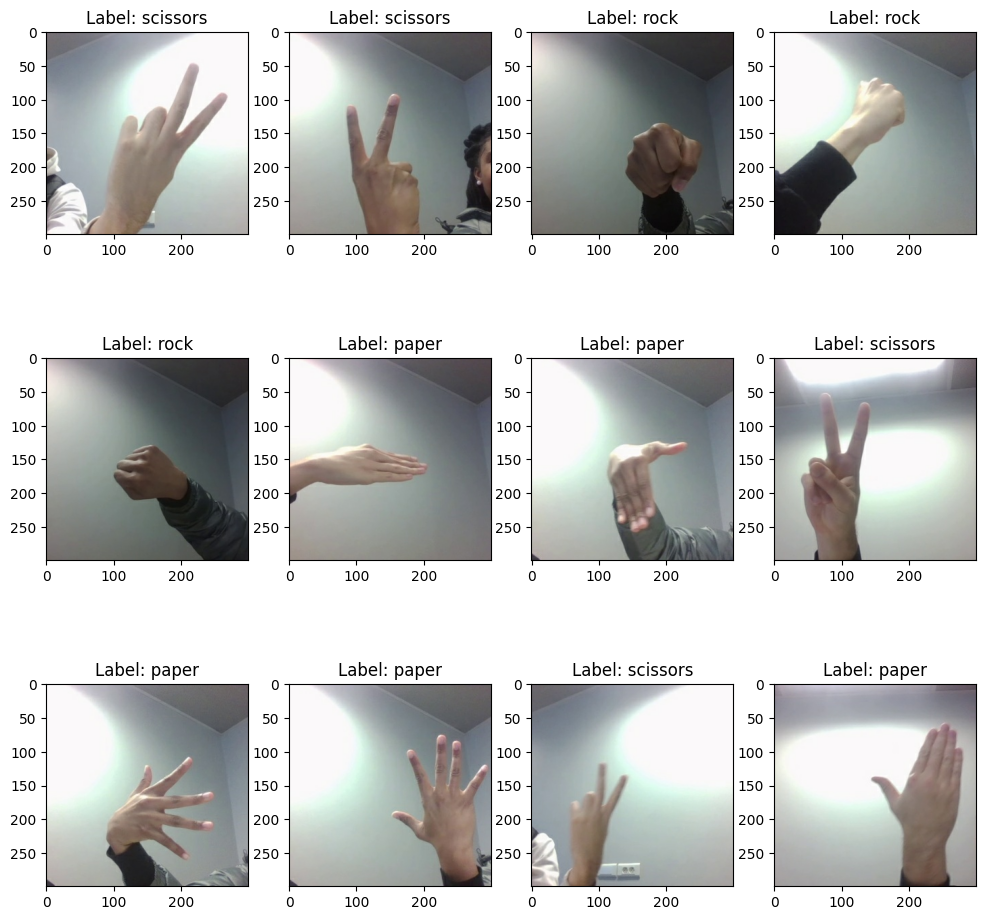

In [9]:
# Explore raw training dataset images.
preview_dataset(dataset_train_raw)

In [10]:
def format_example(features):
    image = features['image']
    label = features['label']
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [11]:
print(dataset_train_raw)
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)
dataset_val = dataset_val_raw.map(format_example)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


Label: 2 

Image shape: (150, 150, 3) 

[[[0.47254902 0.43333334 0.4764706 ]
  [0.47058824 0.43137255 0.46666667]
  [0.46960783 0.44215685 0.46960783]
  ...
  [0.9843137  0.9764706  0.98039216]
  [0.9843137  0.9764706  0.98039216]
  [0.9843137  0.9764706  0.98039216]]

 [[0.46960783 0.43039215 0.47156864]
  [0.4745098  0.43529412 0.47058824]
  [0.46078432 0.43333334 0.46078432]
  ...
  [0.9843137  0.9764706  0.98039216]
  [0.9843137  0.9764706  0.98039216]
  [0.9843137  0.9764706  0.98039216]]

 [[0.47745097 0.43039215 0.46960783]
  [0.4735294  0.4343137  0.46666667]
  [0.46568626 0.43823528 0.46568626]
  ...
  [0.9843137  0.9764706  0.98039216]
  [0.9843137  0.9764706  0.98039216]
  [0.9843137  0.9764706  0.98039216]]

 ...

 [[0.65882355 0.6166667  0.6313726 ]
  [0.76666665 0.71960783 0.73333335]
  [0.92156863 0.8833333  0.89607847]
  ...
  [0.6901961  0.6745098  0.6627451 ]
  [0.6901961  0.6745098  0.6627451 ]
  [0.6901961  0.6745098  0.67058825]]

 [[0.81078434 0.7637255  0.7656863

2024-12-04 20:09:45.102145: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-04 20:09:45.102482: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


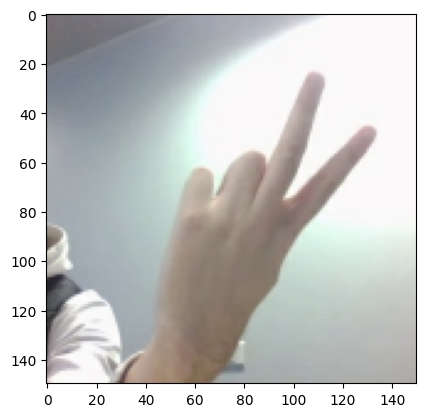

In [12]:
# Explore what values are used to represent the image.
(first_image, first_lable) = list(dataset_train.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())
plt.imshow(first_image.numpy())

In [13]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

In [14]:
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

In [15]:
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

In [16]:
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [17]:
def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    print(image.shape)
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

In [18]:
def augment_data(image, label):
    
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

In [19]:
dataset_train = dataset_train.map(augment_data)
dataset_test = dataset_test.map(augment_data)
dataset_val = dataset_val.map(augment_data)

(150, 150, 3)
(150, 150, 3)
(150, 150, 3)


In [20]:
BATCH_SIZE = 32

dataset_train = dataset_train.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train = dataset_train.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train = dataset_train.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test = dataset_test.batch(BATCH_SIZE)

dataset_val = dataset_val.batch(BATCH_SIZE)

In [21]:
#Load model
model = tf.keras.models.load_model('rock_paper_scissors_cnn.keras')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,946,952 (26.50 MB)

 Trainable params: 3,473,475 (13.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,473,477 (13.25 MB)

In [22]:
# Test model with our dataset
model.evaluate(dataset_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.3397 - loss: 1.9381


[1.9930921792984009, 0.33472222089767456]

# Random Method

In [23]:
def randomTrainDataset(percent):
    dataset_train_random = dataset_train.shuffle(
        buffer_size=NUM_TRAIN_EXAMPLES
    )

    num_take = int(NUM_TRAIN_EXAMPLES * percent)

    dataset_train_random = dataset_train_random.take(
        count=num_take
    )

    steps_per_epoch = num_take // BATCH_SIZE

    return dataset_train_random, steps_per_epoch

def trainModel(epochs, percent):
    model = tf.keras.models.load_model('rock_paper_scissors_cnn.keras')
    dataset_train_random, steps_per_epoch = randomTrainDataset(percent)

    model.fit(
        dataset_train_random.repeat(),
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=dataset_val.repeat(),
        validation_steps=NUM_VAL_EXAMPLES // BATCH_SIZE
    )

    test_loss, test_accuracy = model.evaluate(dataset_test, verbose=1)
    print('Accuracy on test dataset:', test_accuracy)
    print('Loss on test dataset:', test_loss)

    return test_accuracy


# Random results

In [24]:
percentages = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
repeat = 5
average_accuracies = []
min_accuracies = []
max_accuracies = []

for percent in percentages:
    accuracies = []
    for i in range(repeat):
        accuracy = trainModel(10, percent)
        accuracies.append(accuracy)
    average_accuracy = sum(accuracies) / len(accuracies)
    min_accuracy = min(accuracies)
    max_accuracy = max(accuracies)
    average_accuracies.append(average_accuracy)
    min_accuracies.append(min_accuracy)
    max_accuracies.append(max_accuracy)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.3125 - loss: 1.5836 - val_accuracy: 0.3054 - val_loss: 1.3408
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3125 - loss: 1.2537 - val_accuracy: 0.3537 - val_loss: 1.1483
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1875 - loss: 1.1772 - val_accuracy: 0.2997 - val_loss: 1.1495
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4062 - loss: 1.0732 - val_accuracy: 0.3239 - val_loss: 1.1387
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3750 - loss: 1.1139 - val_accuracy: 0.3906 - val_loss: 1.1302
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2812 - loss: 1.0943 - val_accuracy: 0.3849 - val_loss: 1.1287
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2812 - loss: 1.1486 - val_accuracy: 0.3622 - val_loss: 1.1139
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3750 - loss: 1.0898 - val_accuracy: 0.3594 - val_loss: 1.1087
Epoch 9/10
1/1

# Random Graphs 

Average accuracies: [0.33916667103767395, 0.3552777886390686, 0.37166666984558105, 0.3850000023841858, 0.5083333313465118, 0.7838889002799988]
Min accuracies: [0.3291666805744171, 0.3291666805744171, 0.3513889014720917, 0.3583333194255829, 0.4194444417953491, 0.7541666626930237]
Max accuracies: [0.3499999940395355, 0.38055557012557983, 0.4000000059604645, 0.4138889014720917, 0.5888888835906982, 0.8083333373069763]


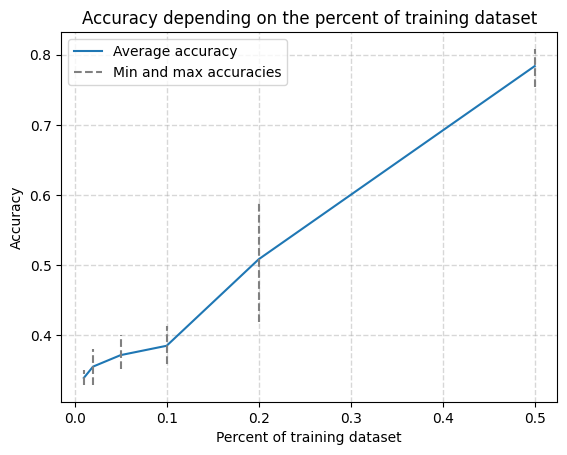

In [26]:
print("Average accuracies:", average_accuracies)
print("Min accuracies:", min_accuracies)
print("Max accuracies:", max_accuracies)

plt.plot(percentages, average_accuracies, label='Average accuracy')
plt.vlines(percentages, min_accuracies, max_accuracies, color='grey', label='Min and max accuracies', linestyles='dashed')
plt.xlabel('Percent of training dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy depending on the percent of training dataset')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()